# Local vs Global Encoding in ZNE: Simulation Framework

This notebook tests whether local or global encoding makes more sense in the context of Zero Noise Extrapolation (ZNE) for partitioned quantum circuits.

## 1. Setup and Imports

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from algs import get_algorithm, create_random_circuit
from partitioning import partitioning
from simulate import (
    run_simulation_experiment, 
    run_batch_experiments,
    create_noise_model
)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Generate Test Circuits

In [21]:
# Configuration
NUM_QUBITS = [4, 6, 8]
ALGORITHMS = ['random', 'qft', 'ghz', 'hardware_efficient']
DEPTH = 5

# Generate circuits
test_circuits = []

for n_qubits in NUM_QUBITS:
    for alg_name in ALGORITHMS:
        try:
            circuit = get_algorithm(alg_name, n_qubits, depth=DEPTH, seed=42)
            test_circuits.append((circuit, f"{alg_name}_{n_qubits}q"))
            print(f"Created {alg_name} circuit with {n_qubits} qubits")
        except Exception as e:
            print(f"Failed to create {alg_name} with {n_qubits} qubits: {e}")

print(f"\nTotal circuits generated: {len(test_circuits)}")

Created random circuit with 4 qubits
Created qft circuit with 4 qubits
Created ghz circuit with 4 qubits
Created hardware_efficient circuit with 4 qubits
Created random circuit with 6 qubits
Created qft circuit with 6 qubits
Created ghz circuit with 6 qubits
Created hardware_efficient circuit with 6 qubits
Created random circuit with 8 qubits
Created qft circuit with 8 qubits
Created ghz circuit with 8 qubits
Created hardware_efficient circuit with 8 qubits

Total circuits generated: 12


## 3. Visualize Sample Circuits

In [22]:
# Display a sample circuit
if test_circuits:
    sample_circuit, sample_name = test_circuits[0]
    print(f"Sample circuit: {sample_name}")
    print(f"Qubits: {sample_circuit.num_qubits}, Depth: {sample_circuit.depth()}")
    print(sample_circuit)

Sample circuit: random_4q
Qubits: 4, Depth: 5
     ┌───┐┌───┐┌───┐    ┌───┐         ┌───┐     
q_0: ┤ T ├┤ Y ├┤ T ├────┤ H ├─────────┤ Z ├─────
     ├───┤├───┤└───┘    ├───┤     ┌───┴───┴────┐
q_1: ┤ Z ├┤ X ├──■──────┤ H ├─────┤ Rx(5.9735) ├
     ├───┤├───┤  │  ┌───┴───┴────┐└────────────┘
q_2: ┤ H ├┤ S ├──┼──┤ Rz(2.3533) ├──────────────
     ├───┤└───┘  │  └───┬───┬────┘              
q_3: ┤ S ├───────■──────┤ Z ├───────────────────
     └───┘              └───┘                   


## 4. Test Single Experiment

Run a single experiment to verify the pipeline works.

In [23]:
# Test with a small circuit
test_qc = create_random_circuit(num_qubits=4, depth=3, seed=42)

print("Testing GLOBAL optimization:")
result_global = run_simulation_experiment(
    circuit=test_qc,
    strategy='global',
    algorithm_name='test_random',
    local_noise=0.01,
    comm_noise_multiplier=1.1,
    comm_primitive='cat',
    shots=1024,
    seed=42
)

print("\nGlobal optimization results:")
for key, value in result_global.items():
    print(f"  {key}: {value}")

print("\n" + "="*60)
print("Testing LOCAL optimization:")
result_local = run_simulation_experiment(
    circuit=test_qc,
    strategy='local',
    algorithm_name='test_random',
    local_noise=0.01,
    comm_noise_multiplier=1.1,
    comm_primitive='cat',
    shots=1024,
    seed=42
)

print("\nLocal optimization results:")
for key, value in result_local.items():
    print(f"  {key}: {value}")

Testing GLOBAL optimization:

Global optimization results:
  origin: test_random
  strategy: global
  communication_noise_multiplier: 1.1
  local_noise: 0.01
  communication_primitive: cat
  num_qubits: 4
  circuit_depth: 5
  partitioned_depth: 7
  num_partitions_requested: 2
  num_partitions_tested: 2
  noise_free_expectation: 0.041015625
  noisy_expectation: -0.041015625
  zne_expectation: -0.001953125
  noisy_error: 0.08203125
  zne_error: 0.04296875
  error_reduction: 0.47619047619047616
  partition_time: 0.001535177230834961
  shots: 1024
  seed: 42

Testing LOCAL optimization:

Local optimization results:
  origin: test_random
  strategy: local
  communication_noise_multiplier: 1.1
  local_noise: 0.01
  communication_primitive: cat
  num_qubits: 4
  circuit_depth: 5
  partitioned_depth: 7
  num_partitions_requested: 2
  num_partitions_tested: 2
  noise_free_expectation: 0.041015625
  noisy_expectation: -0.041015625
  zne_expectation: -0.0625
  noisy_error: 0.08203125
  zne_error:

## 5. Run Batch Experiments

Run comprehensive experiments across all configurations.

In [24]:
# Experimental parameters
STRATEGIES = ['global', 'local']
LOCAL_NOISE_LEVELS = [0.01, 0.02, 0.05]
COMM_NOISE_MULTIPLIERS = [1.0, 1.05, 1.1, 1.2]  # As specified
COMM_PRIMITIVES = ['cat', 'teleportation']
SHOTS = 1024

# Run experiments
results_df = run_batch_experiments(
    circuits=test_circuits[:20],  # Start with subset for testing
    strategies=STRATEGIES,
    noise_levels=LOCAL_NOISE_LEVELS,
    comm_noise_multipliers=COMM_NOISE_MULTIPLIERS,
    comm_primitives=COMM_PRIMITIVES,
    shots=SHOTS,
    output_file='results.csv'
)

print("\nExperiments completed!")
print(f"Total results: {len(results_df)}")

Running 2880 experiments...
Experiment 1/2880: random_4q (4q), global, noise=0.01, comm=1.0x, cat, parts=2
Experiment 2/2880: random_4q (4q), global, noise=0.01, comm=1.0x, cat, parts=4
Experiment 3/2880: random_4q (4q), global, noise=0.01, comm=1.0x, teleportation, parts=2
Experiment 4/2880: random_4q (4q), global, noise=0.01, comm=1.0x, teleportation, parts=4
Experiment 5/2880: random_4q (4q), global, noise=0.01, comm=1.05x, cat, parts=2
Experiment 6/2880: random_4q (4q), global, noise=0.01, comm=1.05x, cat, parts=4
Experiment 7/2880: random_4q (4q), global, noise=0.01, comm=1.05x, teleportation, parts=2
Experiment 8/2880: random_4q (4q), global, noise=0.01, comm=1.05x, teleportation, parts=4
Experiment 9/2880: random_4q (4q), global, noise=0.01, comm=1.1x, cat, parts=2
Experiment 10/2880: random_4q (4q), global, noise=0.01, comm=1.1x, cat, parts=4
Experiment 11/2880: random_4q (4q), global, noise=0.01, comm=1.1x, teleportation, parts=2
Experiment 12/2880: random_4q (4q), global, noi

## 6. Results

Current data summary:
  Total experiments: 1728
  Partition counts: [1, 2, 4, 6, 8]
  Strategies: ['global' 'local']
Loaded 1728 experiments
Unique partition counts: [1, 2, 4, 6, 8]
Strategies: ['global' 'local']

Grouped data:
  strategy  num_partitions_tested          mean           std  count
0   global                      1 -9.948577e-01  3.877803e+00    642
1   global                      2 -4.446809e-16  1.238413e-17     72
2   global                      4 -4.430366e-16  1.341814e-17     72
3   global                      6 -4.422959e-16  1.261758e-17     48
4   global                      8 -4.453587e-16  1.308066e-17     24
5    local                      1 -9.277182e-01  4.254116e+00    645
6    local                      2 -4.438599e-16  1.140464e-17     72
7    local                      4 -4.434985e-16  1.360728e-17     72
8    local                      6 -4.444549e-16  1.317939e-17     48
9    local                      8 -4.484533e-16  1.537470e-17     24

✓ Plot saved

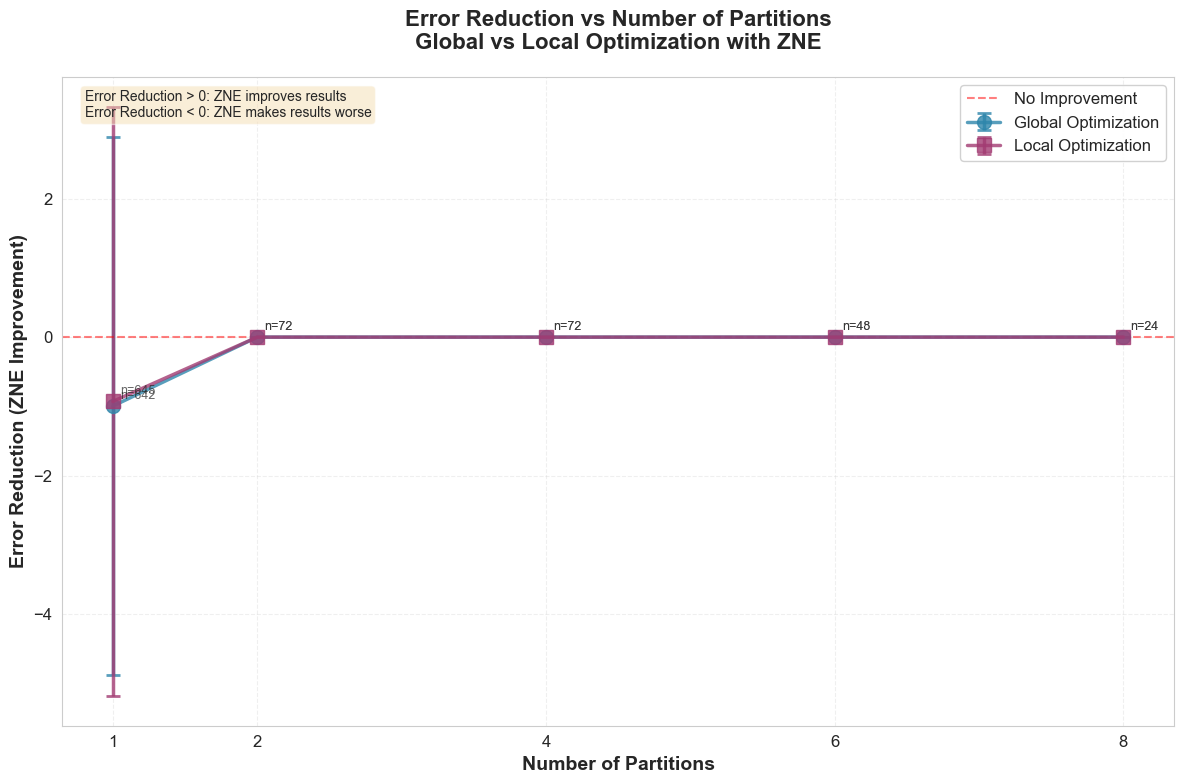


SUMMARY STATISTICS

GLOBAL Strategy:
  Partition counts tested: [1, 2, 4, 6, 8]
  Mean error reduction: -0.1990
  Best partition count: 6 (reduction: -0.0000)

LOCAL Strategy:
  Partition counts tested: [1, 2, 4, 6, 8]
  Mean error reduction: -0.1855
  Best partition count: 4 (reduction: -0.0000)


In [25]:
"""
Script to plot Error Reduction vs Number of Partitions
Compares Global vs Local optimization strategies
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def plot_error_reduction_vs_partitions(csv_file='results.csv', output_file='error_reduction_vs_partitions.png'):
    """
    Plot error reduction vs number of partitions for global and local strategies.
    
    Args:
        csv_file: Path to results CSV file
        output_file: Path to save the plot
    """
    # Load data
    df = pd.read_csv(csv_file)
    
    print(f"Loaded {len(df)} experiments")
    print(f"Unique partition counts: {sorted(df['num_partitions_tested'].unique())}")
    print(f"Strategies: {df['strategy'].unique()}")
    
    # Filter out rows with missing error_reduction
    df_clean = df.dropna(subset=['error_reduction', 'num_partitions_tested'])
    
    if len(df_clean) == 0:
        print("ERROR: No valid data with error_reduction values!")
        print("Make sure your experiments have completed successfully.")
        return
    
    # Group by strategy and num_partitions, calculate mean and std
    grouped = df_clean.groupby(['strategy', 'num_partitions_tested'])['error_reduction'].agg(['mean', 'std', 'count']).reset_index()
    
    print("\nGrouped data:")
    print(grouped)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define colors and markers for each strategy
    colors = {'global': '#2E86AB', 'local': '#A23B72'}
    markers = {'global': 'o', 'local': 's'}
    
    # Plot each strategy
    for strategy in ['global', 'local']:
        strategy_data = grouped[grouped['strategy'] == strategy].sort_values('num_partitions_tested')
        
        if len(strategy_data) == 0:
            print(f"WARNING: No data for {strategy} strategy")
            continue
        
        x = strategy_data['num_partitions_tested']
        y = strategy_data['mean']
        yerr = strategy_data['std']
        
        # Plot line with error bars
        ax.errorbar(x, y, yerr=yerr, 
                   label=f'{strategy.capitalize()} Optimization',
                   marker=markers[strategy], 
                   markersize=10,
                   linewidth=2.5,
                   capsize=5,
                   capthick=2,
                   color=colors[strategy],
                   alpha=0.8)
        
        # Add data point count as text
        for xi, yi, count in zip(x, y, strategy_data['count']):
            ax.annotate(f'n={int(count)}', 
                       xy=(xi, yi), 
                       xytext=(5, 5),
                       textcoords='offset points',
                       fontsize=9,
                       alpha=0.7)
    
    # Formatting
    ax.set_xlabel('Number of Partitions', fontsize=14, fontweight='bold')
    ax.set_ylabel('Error Reduction (ZNE Improvement)', fontsize=14, fontweight='bold')
    ax.set_title('Error Reduction vs Number of Partitions\nGlobal vs Local Optimization with ZNE', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Add horizontal line at y=0 (no improvement)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='No Improvement')
    
    # Legend
    ax.legend(loc='best', fontsize=12, framealpha=0.9)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Set x-axis to show integer partition counts
    if len(grouped['num_partitions_tested'].unique()) > 0:
        partition_counts = sorted(grouped['num_partitions_tested'].unique())
        ax.set_xticks(partition_counts)
        ax.set_xticklabels([int(p) for p in partition_counts])
    
    # Add note about error reduction interpretation
    note_text = "Error Reduction > 0: ZNE improves results\nError Reduction < 0: ZNE makes results worse"
    ax.text(0.02, 0.98, note_text, 
           transform=ax.transAxes,
           fontsize=10,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\n✓ Plot saved to {output_file}")
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    for strategy in ['global', 'local']:
        strategy_data = grouped[grouped['strategy'] == strategy]
        if len(strategy_data) > 0:
            print(f"\n{strategy.upper()} Strategy:")
            print(f"  Partition counts tested: {sorted(strategy_data['num_partitions_tested'].values)}")
            print(f"  Mean error reduction: {strategy_data['mean'].mean():.4f}")
            print(f"  Best partition count: {strategy_data.loc[strategy_data['mean'].idxmax(), 'num_partitions_tested']:.0f} "
                  f"(reduction: {strategy_data['mean'].max():.4f})")


def generate_sample_data_for_testing():
    """
    Generate sample data to test the plotting function.
    This creates synthetic data with different partition counts.
    """
    np.random.seed(42)
    
    data = []
    partition_counts = [1, 2, 4, 6, 8, 10]
    
    for strategy in ['global', 'local']:
        for n_parts in partition_counts:
            for _ in range(5):  # 5 trials per configuration
                # Global tends to do better with more partitions
                if strategy == 'global':
                    base_reduction = 0.3 + 0.05 * n_parts
                else:
                    base_reduction = 0.25 + 0.03 * n_parts
                
                # Add some noise
                error_reduction = base_reduction + np.random.normal(0, 0.1)
                
                data.append({
                    'origin': 'random_4q',
                    'strategy': strategy,
                    'num_partitions_tested': n_parts,
                    'error_reduction': error_reduction,
                    'noisy_error': 0.05,
                    'zne_error': 0.05 * (1 - error_reduction)
                })
    
    df = pd.DataFrame(data)
    df.to_csv('sample_results.csv', index=False)
    print("Generated sample_results.csv for testing")
    return df


if __name__ == "__main__":
    import sys
    
    # Check if results file exists
    import os
    
    if not os.path.exists('results.csv'):
        print("WARNING: results.csv not found!")
        print("Generating sample data for demonstration...")
        generate_sample_data_for_testing()
        plot_error_reduction_vs_partitions('sample_results.csv', 'sample_plot.png')
    else:
        # Load and check the actual data
        df = pd.read_csv('results.csv')
        
        print("Current data summary:")
        print(f"  Total experiments: {len(df)}")
        print(f"  Partition counts: {sorted(df['num_partitions_tested'].unique())}")
        print(f"  Strategies: {df['strategy'].unique()}")
        
        # Check if we have enough data
        n_partitions = len(df['num_partitions_tested'].unique())
        
        if n_partitions < 2:
            print("\n⚠️  WARNING: Only 1 partition count in data!")
            print("   You need to run experiments with multiple partition counts.")
            print("   Run this to generate more data:")
            print("   >>> from simulate import run_batch_experiments")
            print("   >>> from alg import create_random_circuit")
            print("   >>> circuits = [(create_random_circuit(10, 5, seed=i), f'random_{i}') for i in range(3)]")
            print("   >>> df = run_batch_experiments(circuits, partition_counts=[2, 4, 6, 8])")
            print("\nGenerating sample plot with synthetic data for reference...")
            generate_sample_data_for_testing()
            plot_error_reduction_vs_partitions('sample_results.csv', 'sample_plot.png')
        else:
            # Plot the actual data
            plot_error_reduction_vs_partitions('results.csv', 'error_reduction_vs_partitions.png')

# MQT bench

In [ ]:
import sys
sys.argv = ['mqt.py', '3']  

%run mqt.py

MQT Bench Circuit Experiment Runner

Options:
  1. Quick test (1-2 circuits, 2 partition counts) - ~5 minutes
  2. Medium test (2-3 circuits per origin, 4 partition counts) - ~30 minutes
  3. Full experiment (3 circuits per origin, all partitions) - ~1-2 hours

Running full experiment...
MQT BENCH ZNE PARTITIONING EXPERIMENTS

1. DISCOVERING CIRCUITS
----------------------------------------------------------------------
Scanning MQTBench for QASM files...
Found 3877 QASM files
  Loading: graphstate_nativegates_ibm_qiskit_opt0_4.qasm -> graphstate_nativegates_ibm_opt0 (4 qubits)
    ✓ Loaded: graphstate_nativegates_ibm_opt0_4q, depth=18
  Loading: qpeinexact_nativegates_ibm_qiskit_opt0_18.qasm -> qpeinexact_nativegates_ibm_opt0 (18 qubits)
    ✓ Loaded: qpeinexact_nativegates_ibm_opt0_18q, depth=203
  Loading: qwalk-noancilla_indep_qiskit_13.qasm -> qwalk-noancilla_indep (13 qubits)
    ✓ Loaded: qwalk-noancilla_indep_13q, depth=98131
  Loading: qpeexact_nativegates_ibm_qiskit_opt0_86.q